# Image Segmentation

In this section we focus on Image segmentation. 

Segmentation is a process of splitting an image into different parts. For this lets analyse the Cradic Magnetic resonance (MR) imaging data from the **Sunnybrook cardiac database**. Each sunnybrook data contains a 3d time series of a persons heart beat.  

In [1]:
import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import pathlib

In [2]:
# walk through the data 
im_path = pathlib.Path('Data/Sunnybrook Cardiac/')

folder = []
for currentFile in im_path.iterdir():  
    im_folder = currentFile        
    folder.append(im_folder)

folder

[PosixPath('Data/Sunnybrook Cardiac/SCD2001_009'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_007'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_000'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_001'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_006'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_008'),
 PosixPath('Data/Sunnybrook Cardiac/README.md'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_003'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_004'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_005'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_002'),
 PosixPath('Data/Sunnybrook Cardiac/SCD2001_010')]

In [3]:
print('Folders in drive:', len(folder))

files = []        
for currentFile in folder[1].iterdir():  
    im_file = currentFile        
    im = imageio.imread(im_file)
    files.append(im)
    
print('Images in folder', len(files))

Folders in drive: 12
Images in folder 21


In [4]:
import random
[i for i in range(len(files))]

# selecting a random image from the directory. 
img_no = random.choice(np.arange(len(files)))
img_no

7

In [5]:
img = files[img_no]
img

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

(-0.5, 255.5, 255.5, -0.5)

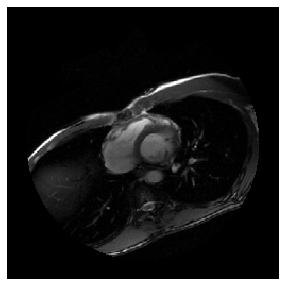

In [6]:
# lets plot the 3D image of the heart
# PLot a random image from folder

plt.figure(figsize=(5,5))
plt.imshow(files[img_no], cmap='gray')
plt.axis('off')

## Segmenting a 3D time series of a heart beat

In [7]:
im_filt = ndi.median_filter(img, size=3)
# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

Num. Labels: 23


In [8]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

Text(0.5, 1.0, 'Labels')

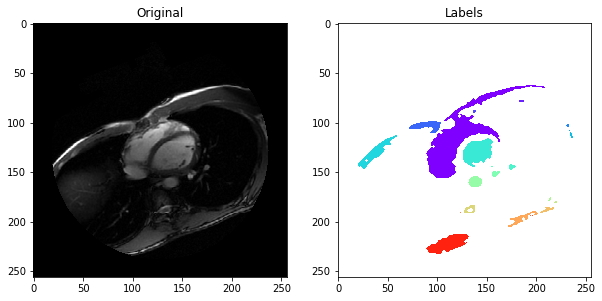

In [9]:
# Plot the labels array on top of the original array. 
# Create a `labels` overlay
# To create an overlay, convert values of 0 to np.nan: 
overlay = np.where(labels>0, labels, np.nan)

# Use imshow to plot the overlay
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(im, cmap='gray')
ax[1].imshow(overlay, cmap='rainbow')
ax[0].set_title(label='Original')
ax[1].set_title(label= 'Labels')

## Object Selection


Labels are like object "handles" - they give you a way to pick up whole sets of pixels at a time. To select a particular object we do two steps. 

- Find the label value associated with the object.
- Create a mask of matching pixels.

### Steps
From the previous image, lets try to highlight the label of the left ventricle. 

- Create a labeled array from the previous mask using `ndi.label()`. 
- Then find the index value of the left ventricle and create a mask of pixels matching the left ventricle label using `np.where()`. 
- Then overlay both images.

In [10]:
labels[120,141]

9

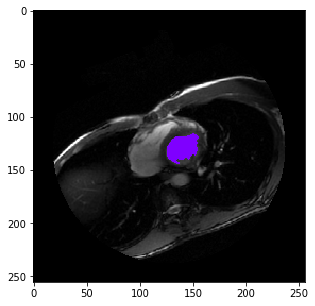

In [11]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[120, 141]

lv_mask = np.where(labels == lv_val,1,np.nan)

# Overlay selected label
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.imshow(lv_mask, cmap='rainbow')

plt.show()

### Bouding boxes

Lets extract the objects from the original image so that it eliminates unrelated pixels so that the new image can be conveniently analysed.

**Idea:** The idea is to crop images such that only the object of interest is included. This is done by implementing a **Bounding Box**. The range of pixel indices that encompass the object is the bounding box.

We do this using scipy's `ndi.find_objects()`

In [12]:
lv_mask = np.where(labels == lv_val,1,0)
lv_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
# Find bounding box of left ventricle
bboxes =ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

Number of objects: 1
Indices for first box: (slice(116, 145, None), slice(126, 156, None))


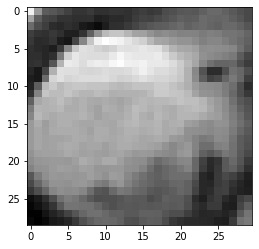

In [14]:
# Select the portion of image img that is within the left ventricle bounding box.
im_lv = img[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv, cmap='gray')

The image locates the vevtricle but is slightly pixelated. The whole point was to demonstrate the use of `ndi.find_objects()`

# Measuring Intensity



In [15]:
vol = np.stack([files[0], files[1], files[3], files[4], files[5], files[6], files[7], files[8], files[9], files[10], files[11]])
vol.shape

(11, 256, 256)

In [16]:
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])

All pixels: 846.6687787430641
Labeled pixels: 1847.8019239060382
Left ventricle: 2130.337634548555
Other tissue: 39.256942148760324


## Histogram

A perfectly segmented left ventricle would only contain blood related pixels. Hense the histogram of segmented values would be bell shaped. Lets see if that is the case. 

In [17]:
labels.shape

(256, 256)

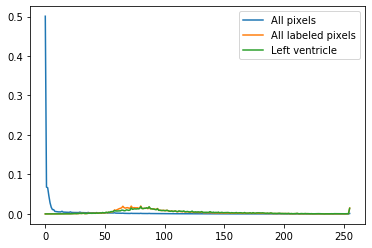

In [18]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
plt.legend(loc='best')
# Note: each plot is rescaled amongst itself to allow comparison. 

## Measuring Morphology


**[Morphology](https://en.wikipedia.org/wiki/Morphology_(biology))** deals with the study of form and structure of an organism. Every time we come across a *tumor*, the natural question to ask is how big is it or doctors after studying it for a while, would eventually like to know if they have grown or not. 

So the **Spacial Extent** is determined by $\text(Space \qquad occupied \qquad by \qquad each \qquad element) \times \text(Number \qquad of \qquad array \qquad elements)$

In [19]:
# vol per voxel is calculated as 

ndi.sum(1, labels, index=1)

2249

In [20]:
# calculate distance

# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling=[2,1])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan)

Max distance (mm): 14.560219778561036
Max location: (132, 104)


Label 1 center: (4.972366548707235, 108.57890159774945, 126.3121144818766)
Label 2 center: (5.004328043502386, 78.52724447897015, 184.06103651093107)


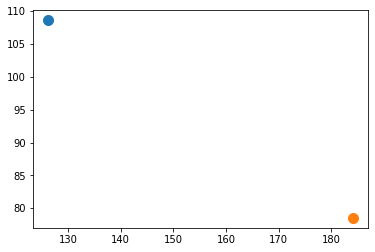

In [21]:
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot 
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()

## Ejection fraction


The ejection fraction is the proportion of blood squeezed out of the left ventricle each heartbeat. To calculate it, radiologists have to identify the maximum volume (systolic volume) and the minimum volume (diastolic volume) of the ventricle.




In [23]:
# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d0, d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel

# Plot the data
plt.plot(ts)
format_and_render_plot()

NameError: name 'vol_ts' is not defined

The ejection fraction is given as $\frac{V_{max} - V_{min}}{V_{max}}$ where V is the left ventricle volume for one 3D timeplant. 